# Self-Drive Cars' Sentiment Analysis

- Implementing model based on previous notebook work
- Taking care of imbalnced classes issue

# 1)- Importing modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2)- Load Data

In [87]:
import pickle
#Loading from firm cleaned file
df = pd.read_pickle('model.pkl')
df.shape

(15000, 2)

In [88]:
df.head()

,TEXT,Sent_type
143880,"""Over the years, the MLK estate has also licen...",Benefit
87455,Porsche celebrates its racing history with the...,Benefit
103986,"Hmm, could that be the Mercedes? It made a ver...",Risky
261437,The Full Carbon Audi RS6 is simply Amazing pi...,Benefit
205444,Vijay Mayadas explores #blockchain potential i...,Benefit


In [89]:
df.sort_index(ascending=True)

,TEXT,Sent_type
6,"Oshey version of ""theChefchi"". Porsche and as...",Benefit
37,"He's rocking it in Tampa tonight! Great crowd,...",Benefit
100,Munich is an amazing city full of so many surp...,Benefit
103,Prince Harry’s @Audi RS6 Avant up for sale: ht...,Neutral
108,Porsche Taycan will have dual electric motors ...,Neutral
...,...,...
455623,The more I find out about BMW the more impress...,Benefit
455686,Mercedes doesn't like Billy Joel therefore I d...,Risky
455690,"Earlier today Lauren said ""would you rather ta...",Neutral
455717,Techart based on Porsche 911 997 GT3 pic.twitt...,Neutral


In [95]:
df.Sent_type.value_counts()

Neutral    6513
Benefit    5912
Risky      2575
Name: Sent_type, dtype: int64

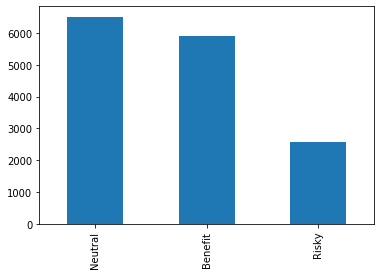

In [6]:
df.Sent_type.value_counts().plot(kind='bar')

In [7]:
df.Sent_type.value_counts(normalize=True)

Neutral    0.434200
Benefit    0.394133
Risky      0.171667
Name: Sent_type, dtype: float64

# 3)- Cleaning

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http','https','pictwittercom']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [9]:
df['cleaned']=[text_prepare(x) for x in df['TEXT']]

In [10]:
print(df.TEXT[:5])

143880    "Over the years, the MLK estate has also licen...
87455     Porsche celebrates its racing history with the...
103986    Hmm, could that be the Mercedes? It made a ver...
261437    The Full Carbon Audi RS6 is simply Amazing  pi...
205444    Vijay Mayadas explores #blockchain potential i...
Name: TEXT, dtype: object


In [11]:
df.cleaned[:5]

143880    years mlk estate also licensed king speeches u...
87455     porsche celebrates racing history 911 carrera ...
103986    hmm could mercedes made strange noise hamilton...
261437       full carbon audi rs6 simply amazing lurgrsmbqs
205444    vijay mayadas explores blockchain potential ch...
Name: cleaned, dtype: object

In [13]:
df.cleaned[143880]

'years mlk estate also licensed king speeches used ads alcatel apple chevrolet mercedes add dodge list sued makers eyes prize wwwpoliticocom magazine story 2015 01 selmamartinlutherkingcanyoucopyrightadream114187'

### most common words

In [14]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in df['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('selfdriving', 2738),
 ('bmw', 2367),
 ('porsche', 2177),
 ('cars', 1896),
 ('car', 1754),
 ('motors', 1693),
 ('mercedes', 1606),
 ('audi', 1458),
 ('new', 1150),
 ('general', 1123)]

# 4)-RNN

- Applying LSTM

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [16]:
df.head()

,TEXT,Sent_type,cleaned
143880,"""Over the years, the MLK estate has also licen...",Benefit,years mlk estate also licensed king speeches u...
87455,Porsche celebrates its racing history with the...,Benefit,porsche celebrates racing history 911 carrera ...
103986,"Hmm, could that be the Mercedes? It made a ver...",Risky,hmm could mercedes made strange noise hamilton...
261437,The Full Carbon Audi RS6 is simply Amazing pi...,Benefit,full carbon audi rs6 simply amazing lurgrsmbqs
205444,Vijay Mayadas explores #blockchain potential i...,Benefit,vijay mayadas explores blockchain potential ch...


In [17]:
y=df['Sent_type']

In [18]:
df['cleaned'].shape

(15000,)

In [19]:
X=df.cleaned

In [20]:
print(X.shape)
print(y.shape)

(15000,)
(15000,)


## Step1- Convert words to matrix

We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

- Vectorize tweet, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,000 words.
- Set the max number of words in each complaint at 280(max size limit for twitter is 280 ).


### i-I started by fitting a tokenizer on my document as in here:

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 280
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)

In [22]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50716 unique tokens.


### ii- I wanted to check if my data is fitted correctly so I converted into sequence

In [23]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X.values)

In [24]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,73.0,1792.0,158.0,1537.0,181.0,1462.0,189.0,398.0,7.0,1212.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,2674.0,104.0,496.0,37.0,450.0,1793.0,104.0,451.0,2031.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69.0,7.0,99.0,4067.0,3610.0,277.0,1794.0,2935.0,78.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,146.0,1463.0,8.0,1325.0,2167.0,380.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1213.0,1795.0,245.0,1326.0,59.0,23.0,1159.0,1.0,4.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It means that "two" is encoded as 153, "places" as 944 and so on...... "selfdriving" as 5 and finally "cars" as 3

In [25]:
df.head()

,TEXT,Sent_type,cleaned
143880,"""Over the years, the MLK estate has also licen...",Benefit,years mlk estate also licensed king speeches u...
87455,Porsche celebrates its racing history with the...,Benefit,porsche celebrates racing history 911 carrera ...
103986,"Hmm, could that be the Mercedes? It made a ver...",Risky,hmm could mercedes made strange noise hamilton...
261437,The Full Carbon Audi RS6 is simply Amazing pi...,Benefit,full carbon audi rs6 simply amazing lurgrsmbqs
205444,Vijay Mayadas explores #blockchain potential i...,Benefit,vijay mayadas explores blockchain potential ch...


In [27]:
df['cleaned'][143880]

'years mlk estate also licensed king speeches used ads alcatel apple chevrolet mercedes add dodge list sued makers eyes prize wwwpoliticocom magazine story 2015 01 selmamartinlutherkingcanyoucopyrightadream114187'

In [28]:
df['cleaned'][103986]

'hmm could mercedes made strange noise hamilton passed pits f1'

**google is encoded as 4. And cars as 3 . car as 2. Let's confirm our encoding scheme with one more**

In [29]:
df['cleaned'][205444]

'vijay mayadas explores blockchain potential china impact tech like 5g selfdriving cars scmp_news owly nxef309orempictwittercom us7a02saia'

Perfect google is 4 and cars is 3

###  pad_sequence:To keep all vectors of same length, I will use pad_sequence

In [30]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (15000, 280)


To avoid AttributeError: 'numpy.ndarray' object has no attribute 'head', we will check in dataframe. Still input to neural network will be numpy array not dataframe

In [32]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0,0,0,0,0,0,0,0,0,0,...,2673,991,2934,1695,915,2487,1385,159,511,345
1,0,0,0,0,0,0,0,0,0,0,...,2674,104,496,37,450,1793,104,451,2031,3
2,0,0,0,0,0,0,0,0,0,0,...,0,69,7,99,4067,3610,277,1794,2935,78
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,146,1463,8,1325,2167,380
4,0,0,0,0,0,0,0,0,0,0,...,1795,245,1326,59,23,1159,1,4,19,40


**All in one step**

In [33]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(X)
#X = tokenizer.texts_to_sequences(X)
#X = pad_sequences(X)

In [34]:
#X_pd_sq.shape

## Step 2- Train-test split

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq,y,random_state=42)

In [36]:
X_train.shape, X_test.shape

((11250, 280), (3750, 280))

In [37]:
print(y_train.shape)
print(y_test.shape)

(11250,)
(3750,)


## Step 3- Encoding y-labeled feature

In [38]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [39]:
y_train[:5]

32374     Benefit
66909     Benefit
119175    Benefit
175091    Benefit
117650    Neutral
Name: Sent_type, dtype: object

In [40]:
y_train_ohe[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [41]:
y_test[:5]

381167    Neutral
17841     Neutral
357487    Benefit
47925     Benefit
368707    Benefit
Name: Sent_type, dtype: object

In [42]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

From above, we can see what is encoding scheme

- Neutral is 0,1,0
- Risky is 0,0,1
- Beneficial is 1,0,0

In [43]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['Neutral', 'Benefit', 'Risky']

In [44]:
len(unique_y_labels)

3

**Hence , our last dense layer will be of size 3

## Step 4- Build LSTM model

- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 3 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function


In [45]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
# for our padding seq
input_length=X_pd_sq.shape[1]
uniq_y_label=len(unique_y_labels)

In [46]:
X_pd_sq.shape[1]

280

In [47]:
uniq_y_label

3

**Stacked LSTM with 100 hidden units and input size 280 (whose outputs are concatenated)**

We can reduce this size by 50. Mostly 64 is given as hidden layer and 128 for embedding layer. We have more of a comprehensive data so we have given different values.
Embed dim could be also 200 or even higher.

In [48]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq.shape[1]))
#model.add(SpatialDropout1D(0.2))
model.add(Dropout(0.2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 100)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 580,703
Trainable params: 580,703
Non-trainable params: 0
_________________________________________________________________
None


### preview of summary and params calculations

https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889

- Formula for Parameter calculation for RNN - LSTM 

g × [h(h+i) + h]


g= 4(LSTM has 4 FFNNs), h=100 , i= 280

**For simple Neural Network**


num param= (i×h + h×o) + (h+o)

 where (h+o) is biaseness <br>
- i, input size
- h, size of hidden layer
- o, output size

**How are these results come up**

- 1. embedding_1 (Embedding)

MAX_NB_WORDS = 5000. Multiply this with EMBEDDING_DIM = 100. We get 500,000.

- 2. dropout_1 (Dropout): No parameter is calculated at this point. It performs an action

- 3.lstm_1 (LSTM)

500.000 i.e total param from above are multiplied by 0.8. As we have one recurrent dropout and one normal dropout. It is of 0.2 and hence it will reduce our data 20% and we are left with 80%. That is why division by 0.8
 
500.000 * 0.8 = 400.000 ...............this will be multiplied by 2 as of 2 dropout layers.So we have 800.000
 
As for this point, we have (None, 100) meaning we have 100 hidden layer units and LSTM has 4 Feed Forward NNs. So 100*4=400

Summing up all, 800.000+400= 80400


- dense_1 (Dense) :

100(Embedding DIM) multiply by 3(last dense layer as size of output classes) = 300 +3(size of output) 

- Total Param= adding all i.e 500,000+0+80400+0+303= 580,703

**What does 'None' mean?** i.e (None, 280, 100)

- None means this dimension is variable.

The first dimension in a keras model is always the batch size. You don't need fixed batch sizes, unless in very specific cases (for instance, when working with stateful=True LSTM layers).

That's why this dimension is often ignored when you define your model. For instance, when you define input_shape=(100,200), actually you're ignoring the batch size and defining the shape of "each sample". Internally the shape will be (None, 100, 200), allowing a variable batch size, each sample in the batch having the shape (100,200).

The batch size will be then automatically defined in the fit or predict methods.

### Taking care of Imbalanced class issue

In [50]:
from sklearn.utils import class_weight

In [51]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

## Step 5- Train model

In [52]:
batch_size = 64
epochs = 15

In [53]:
from keras.callbacks import EarlyStopping

In [54]:
%%time
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,class_weight=class_weights,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10125 samples, validate on 1125 samples
Epoch 1/15
10125/10125 [==============================] - 73s 7ms/step - loss: 0.9327 - accuracy: 0.5544 - val_loss: 0.7292 - val_accuracy: 0.7031
Epoch 2/15
10125/10125 [==============================] - 78s 8ms/step - loss: 0.4978 - accuracy: 0.8181 - val_loss: 0.5927 - val_accuracy: 0.7804
Epoch 3/15
10125/10125 [==============================] - 79s 8ms/step - loss: 0.2992 - accuracy: 0.8986 - val_loss: 0.6161 - val_accuracy: 0.7884
Epoch 4/15
10125/10125 [==============================] - 79s 8ms/step - loss: 0.2224 - accuracy: 0.9275 - val_loss: 0.6663 - val_accuracy: 0.7911
Epoch 5/15
10125/10125 [==============================] - 79s 8ms/step - loss: 0.1756 - accuracy: 0.9447 - val_loss: 0.7602 - val_accuracy: 0.7813


In [94]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3750/3750 [==============================] - 7s 2ms/step
Test set
  Loss: 0.677
  Accuracy: 0.811


## Step 6- Evaluate

In [56]:
y_pred = model.predict(X_test)

In [57]:
y_pred[:5]

array([[2.3440903e-01, 7.1820807e-01, 4.7382887e-02],
       [1.3797609e-03, 9.9688256e-01, 1.7378114e-03],
       [9.9439079e-01, 4.4180816e-03, 1.1911216e-03],
       [9.9418712e-01, 5.3478023e-03, 4.6501850e-04],
       [2.6500069e-02, 9.4846386e-01, 2.5035994e-02]], dtype=float32)

**These are probabilities of output**

In [58]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [59]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

**Converting prob. into crisp classes i.e in 1D.**

In [60]:
y_test_class[:5]

array([1, 1, 0, 0, 0], dtype=int64)

**By comparing from y_test_ohe, we can see that '1' in y_test_class means neutral. <br>
2 means [0,0,1] of y_test_ohe .It means we have Risky component<br>
0 means [1,0,0] which means beneficial**

In [61]:
y_pred_class[:5]

array([1, 1, 0, 0, 1], dtype=int64)

### a)- Classification Report

In [62]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1512
           1       0.83      0.87      0.85      1606
           2       0.70      0.59      0.64       632

    accuracy                           0.81      3750
   macro avg       0.79      0.77      0.77      3750
weighted avg       0.81      0.81      0.81      3750



0 is Beneficial<br>
1 is Neutral <br>
2 is Risky<br>

In [63]:
y_test.value_counts()

Neutral    1606
Benefit    1512
Risky       632
Name: Sent_type, dtype: int64

### b)-Confusion Matrix

In [64]:
cm=confusion_matrix(y_test_class,y_pred_class)
print(cm)

[[1266  164   82]
 [ 122 1402   82]
 [ 135  123  374]]


In [65]:
y_test.value_counts()

Neutral    1606
Benefit    1512
Risky       632
Name: Sent_type, dtype: int64

<Figure size 720x720 with 0 Axes>

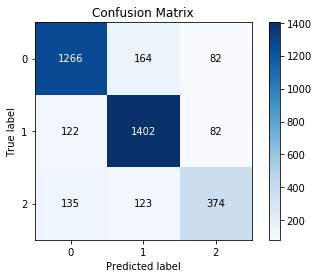

In [66]:
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class)
plt.show()

In [67]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

[[0.83730159 0.10846561 0.0542328 ]
 [0.07596513 0.87297634 0.05105853]
 [0.21360759 0.19462025 0.59177215]]


<Figure size 720x720 with 0 Axes>

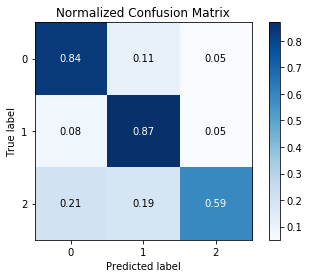

In [68]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(y_test_class,y_pred_class, normalize=True)
plt.show()

### c)- Loss and Accuracy

In [69]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9533
Training Loss: 0.1697


In [70]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.8112
Testing Loss:  0.6767


In [71]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

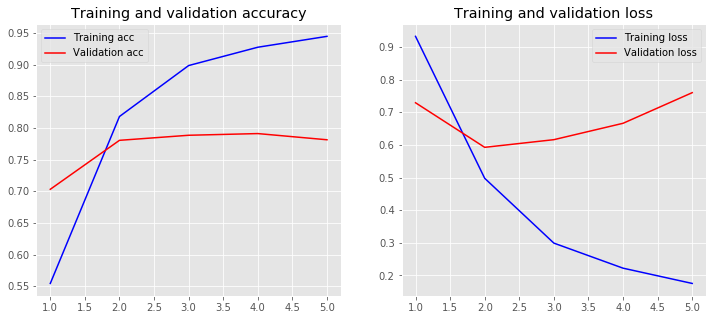

In [72]:
plot_history(history)

In [73]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history2(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

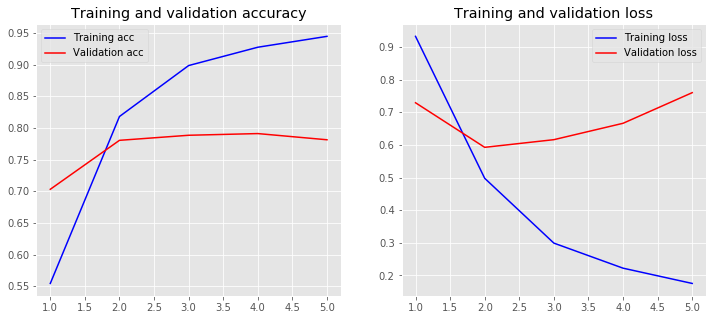

In [74]:
plot_history(history)

### d)- Checking results test set

In [75]:
y_test[:5]

381167    Neutral
17841     Neutral
357487    Benefit
47925     Benefit
368707    Benefit
Name: Sent_type, dtype: object

In [76]:
y_test_ohe[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [77]:
prediction=model.predict(X_test)
prediction[:5]

array([[2.3440903e-01, 7.1820807e-01, 4.7382887e-02],
       [1.3797609e-03, 9.9688256e-01, 1.7378114e-03],
       [9.9439079e-01, 4.4180816e-03, 1.1911216e-03],
       [9.9418712e-01, 5.3478023e-03, 4.6501850e-04],
       [2.6500069e-02, 9.4846386e-01, 2.5035994e-02]], dtype=float32)

In [78]:
df.head()

,TEXT,Sent_type,cleaned
143880,"""Over the years, the MLK estate has also licen...",Benefit,years mlk estate also licensed king speeches u...
87455,Porsche celebrates its racing history with the...,Benefit,porsche celebrates racing history 911 carrera ...
103986,"Hmm, could that be the Mercedes? It made a ver...",Risky,hmm could mercedes made strange noise hamilton...
261437,The Full Carbon Audi RS6 is simply Amazing pi...,Benefit,full carbon audi rs6 simply amazing lurgrsmbqs
205444,Vijay Mayadas explores #blockchain potential i...,Benefit,vijay mayadas explores blockchain potential ch...


In [80]:
# checking with original text at index 225777. It is risky
df.TEXT.loc[205444]

'Vijay Mayadas explores #blockchain potential in China and impact on tech like 5G and self-driving cars in @SCMP_News http://ow.ly/nxEf309oREM\xa0pic.twitter.com/US7A02sAiA'

In [81]:
df.loc[261437]

TEXT         The Full Carbon Audi RS6 is simply Amazing  pi...
Sent_type                                              Benefit
cleaned         full carbon audi rs6 simply amazing lurgrsmbqs
Name: 261437, dtype: object

In [84]:
#[print(df['TEXT'][i], y_pred[i], y_test_ohe[i]) for i in range(143880, 205444)]

**Interpret**

- We have checked 1st five sentiment from 'text' feature. So, 1st column is text<br>
- 2nd column is predicted results. These are probability values of each sentiment. 0 ,1,2 as they were encoded. 'Risky':0, 'Beneficial':1, 'Neutral':2. So, 0 is risky, 1 is beneficial and 2 is neut. Probability of risky is 0.15, beneficial is 0.819 and neut is 0.119. Clearly, this text has tendency to be beneficial having highest probability<br>
- Third column shows real values of sentiment. Sequence is same as we encoded. And we can see that actual text was of beneficial sentiment. So, our prediction is correct in this case

In [85]:
ben_count, neu_count, risk_count = 0, 0, 0
real_ben, real_neu, real_risk = 0, 0, 0
for i, y_pred in enumerate(y_pred):
    if np.argmax(y_pred)==2:
        risk_count += 1
    elif np.argmax(y_pred)==1:
        neu_count += 1
    else:
        ben_count += 1
    
    if np.argmax(y_test_ohe[i])==2:
        real_risk += 1
    elif np.argmax(y_test_ohe[i])==1:    
        real_neu += 1
    else:
        real_ben +=1

print('Benefit predictions:', ben_count)
print('Neutral predictions:', neu_count)
print('Risk predictions:', risk_count)
print('Real Benefit values:', real_ben)
print('Real neutral values:', real_neu)
print('Real Risk values:', real_risk)

Benefit predictions: 1523
Neutral predictions: 1689
Risk predictions: 538
Real Benefit values: 1512
Real neutral values: 1606
Real Risk values: 632


test set has 3750.<br>
Real values are risky as 632, neutral as 1606, benefit as 1512<br>
We predicted Risky as 480, neutral as 1699, benefit as  15716<br>

In [86]:
y_test.value_counts(ascending=True)

Risky       632
Benefit    1512
Neutral    1606
Name: Sent_type, dtype: int64